# Data Exploration for Personalized Targeting Experiments

This notebook explores the structure and statistics of experimental data from the personalized targeting system.

## 1. Experiment Overview

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Specify experiment directory to analyze
EXPERIMENT_DIR = "results/simulation_20250819_185550"  # Change this to your experiment
experiment_path = Path(EXPERIMENT_DIR)

# Check if experiment exists
if not experiment_path.exists():
    print(f"❌ Experiment directory not found: {EXPERIMENT_DIR}")
    print("Available experiments:")
    results_dir = Path("results")
    if results_dir.exists():
        for exp_dir in sorted(results_dir.glob("simulation_*")):
            print(f"  📁 {exp_dir.name}")
else:
    print(f"✅ Analyzing experiment: {EXPERIMENT_DIR}")
    
    # Load simulation configuration
    config_file = experiment_path / "simulation_config.json"
    if config_file.exists():
        with open(config_file, 'r') as f:
            config = json.load(f)
        print(f"\n📋 Experiment Configuration:")
        print(f"  Timestamp: {config.get('timestamp', 'N/A')}")
        print(f"  Iterations: {config.get('iterations', 'N/A')}")
        print(f"  Users: {config.get('users', 'N/A')}")
        print(f"  Initial Actions: {config.get('initial_actions', 'N/A')}")
        print(f"  Company Strategy: {config.get('company_strategy', 'N/A')}")
        print(f"  Ground Truth Type: {config.get('ground_truth_type', 'N/A')}")
        print(f"  Reward Model Type: {config.get('reward_model_type', 'N/A')}")
    else:
        print("⚠️ No configuration file found")

✅ Analyzing experiment: results/simulation_20250819_185550

📋 Experiment Configuration:
  Timestamp: 20250819_185550
  Iterations: 4
  Users: 10000
  Initial Actions: 30
  Company Strategy: linucb
  Ground Truth Type: mixture_of_experts
  Reward Model Type: doubly_robust


## 2. User Analysis

In [3]:
# Load users data
def load_users_data(experiment_path):
    """Load user data from experiment."""
    users_file = experiment_path / "iteration_0" / "users" / "users.json"
    segments_file = experiment_path / "iteration_0" / "users" / "user_segments.json"
    
    users_data = None
    segments_data = None
    
    if users_file.exists():
        with open(users_file, 'r') as f:
            users_data = json.load(f)
    
    if segments_file.exists():
        with open(segments_file, 'r') as f:
            segments_data = json.load(f)
    
    return users_data, segments_data

# Load user data
if experiment_path.exists():
    users_data, segments_data = load_users_data(experiment_path)
    
    if users_data:
        print(f"👥 User Statistics:")
        print(f"  Total users: {len(users_data['users'])}")
        
        # Extract user features for analysis
        user_features = []
        user_segments = []
        
        for user in users_data['users']:
            user_features.append(user['feature_vector'])
            user_segments.append(user.get('segment', 'unknown'))
        
        user_features = np.array(user_features)
        
        # Feature names (from CLAUDE.md)
        feature_names = [
            'age', 'income', 'tech_savviness', 'price_sensitivity', 
            'brand_loyalty', 'social_influence', 'urgency_response', 'quality_focus'
        ]
        
        print(f"\n📊 User Feature Statistics:")
        for i, feature_name in enumerate(feature_names):
            values = user_features[:, i]
            print(f"  {feature_name:15}: mean={values.mean():.3f}, std={values.std():.3f}, range=[{values.min():.3f}, {values.max():.3f}]")
        
        # Segment distribution
        from collections import Counter
        segment_counts = Counter(user_segments)
        print(f"\n🏷️ User Segment Distribution:")
        for segment, count in segment_counts.items():
            percentage = count / len(user_segments) * 100
            print(f"  {segment:25}: {count:4d} users ({percentage:5.1f}%)")
    
    else:
        print("❌ No users data found")
else:
    print("❌ Experiment directory not found")

👥 User Statistics:
  Total users: 10000

📊 User Feature Statistics:
  age            : mean=0.484, std=0.179, range=[0.000, 1.000]
  income         : mean=0.610, std=0.237, range=[0.000, 1.000]
  tech_savviness : mean=0.632, std=0.179, range=[0.003, 1.000]
  price_sensitivity: mean=0.577, std=0.276, range=[0.000, 1.000]
  brand_loyalty  : mean=0.624, std=0.229, range=[0.000, 1.000]
  social_influence: mean=0.566, std=0.212, range=[0.000, 1.000]
  urgency_response: mean=0.607, std=0.204, range=[0.000, 1.000]
  quality_focus  : mean=0.672, std=0.215, range=[0.019, 1.000]

🏷️ User Segment Distribution:
  premium_customer         : 2031 users ( 20.3%)
  young_tech_savvy         : 2462 users ( 24.6%)
  budget_conscious_family  : 2480 users ( 24.8%)
  middle_aged_professional : 3027 users ( 30.3%)


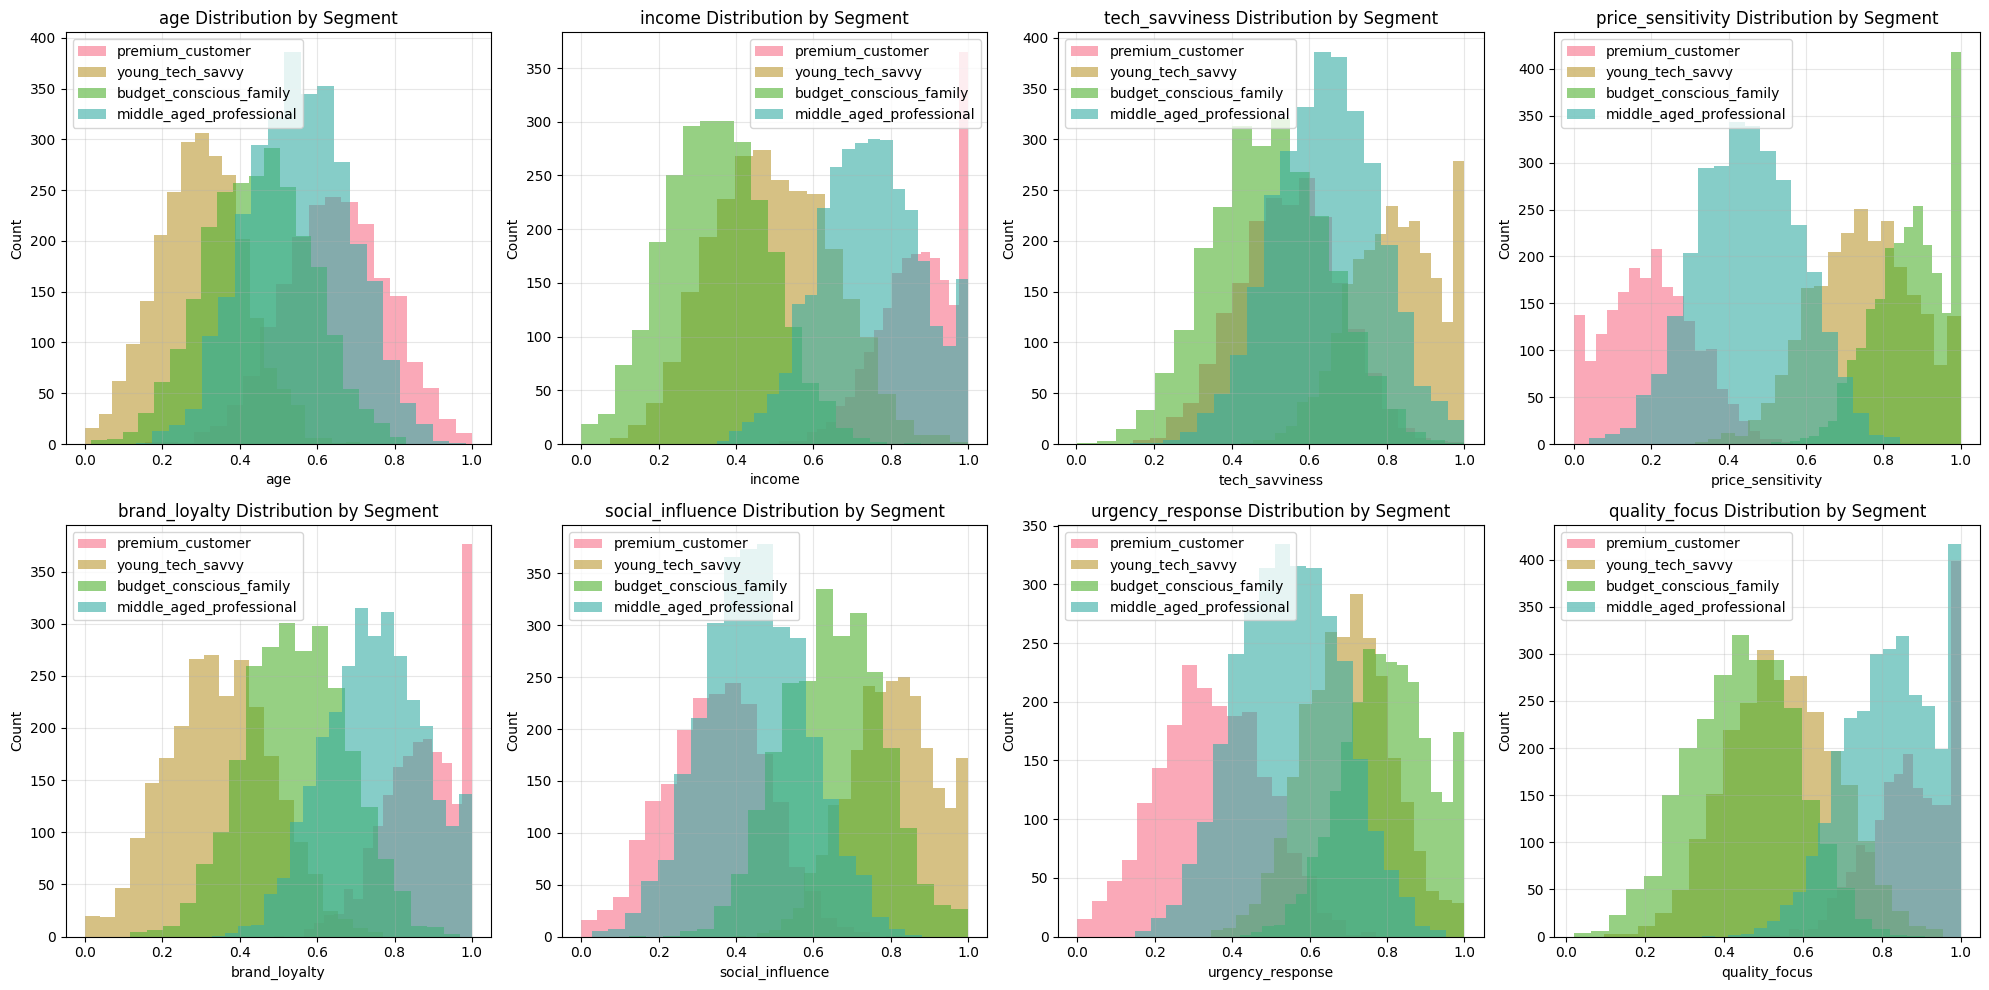

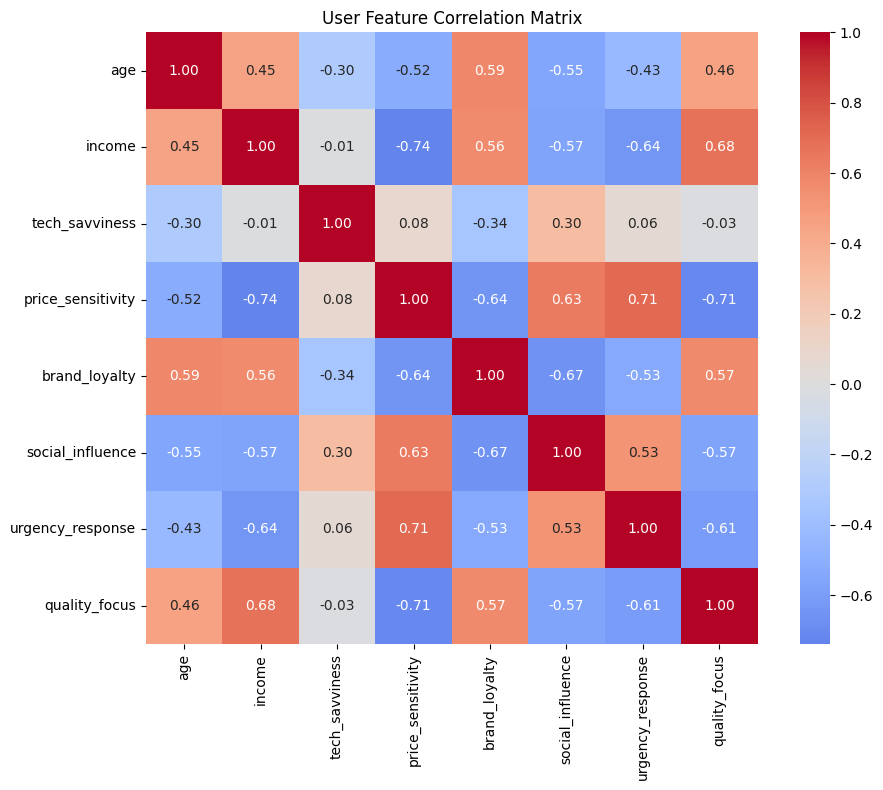


📈 Feature Statistics by Segment:
                            age        income        tech_savviness         \
                           mean    std   mean    std           mean    std   
segment                                                                      
budget_conscious_family   0.447  0.134  0.351  0.133          0.498  0.149   
middle_aged_professional  0.555  0.131  0.744  0.129          0.645  0.133   
premium_customer          0.648  0.133  0.867  0.099          0.549  0.130   
young_tech_savvy          0.299  0.112  0.494  0.155          0.819  0.114   

                         price_sensitivity        brand_loyalty         \
                                      mean    std          mean    std   
segment                                                                  
budget_conscious_family              0.868  0.094         0.547  0.131   
middle_aged_professional             0.452  0.133         0.749  0.126   
premium_customer                     0.201  0.113

In [4]:
# Visualize user feature distributions
if experiment_path.exists() and users_data:
    # Create user features DataFrame for easier analysis
    user_df = pd.DataFrame(user_features, columns=feature_names)
    user_df['segment'] = user_segments
    
    # Plot feature distributions by segment
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(feature_names):
        ax = axes[i]
        
        # Plot histogram for each segment
        for segment in user_df['segment'].unique():
            segment_data = user_df[user_df['segment'] == segment][feature]
            ax.hist(segment_data, alpha=0.6, label=segment, bins=20)
        
        ax.set_title(f'{feature} Distribution by Segment')
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = user_df[feature_names].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title('User Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Segment summary statistics
    print("\n📈 Feature Statistics by Segment:")
    segment_stats = user_df.groupby('segment')[feature_names].agg(['mean', 'std'])
    print(segment_stats.round(3))

## 3. Action Bank Analysis

In [5]:
# Load action bank data across iterations
def load_action_banks(experiment_path):
    """Load action banks from all iterations."""
    action_banks = {}
    
    # Load initial action bank (iteration 0)
    initial_bank_file = experiment_path / "iteration_0" / "action_bank" / "action_bank.json"
    if initial_bank_file.exists():
        with open(initial_bank_file, 'r') as f:
            action_banks[0] = json.load(f)
    
    # Load action banks from subsequent iterations
    iteration_dirs = sorted([d for d in experiment_path.glob("iteration_*") if d.is_dir()])
    
    for iter_dir in iteration_dirs:
        iter_num = int(iter_dir.name.split("_")[1])
        
        # Current action bank used in this iteration
        current_bank_file = iter_dir / "action_bank" / "action_bank.json"
        if current_bank_file.exists():
            with open(current_bank_file, 'r') as f:
                action_banks[f"{iter_num}_current"] = json.load(f)
        
        # New action bank generated by algorithm
        new_bank_file = iter_dir / "new_action_bank" / "new_action_bank.json"
        if new_bank_file.exists():
            with open(new_bank_file, 'r') as f:
                action_banks[f"{iter_num}_new"] = json.load(f)
    
    return action_banks

if experiment_path.exists():
    action_banks = load_action_banks(experiment_path)
    
    print(f"🎯 Action Bank Analysis:")
    print(f"  Found {len(action_banks)} action banks")
    
    # Analyze each action bank
    for bank_key, bank_data in action_banks.items():
        actions = bank_data.get('actions', [])
        print(f"\n📋 {bank_key}:")
        print(f"  Total actions: {len(actions)}")
        
        if actions:
            # Analyze action categories
            categories = [action.get('category', 'unknown') for action in actions]
            from collections import Counter
            category_counts = Counter(categories)
            print(f"  Categories: {dict(category_counts)}")
            
            # Analyze action text lengths
            text_lengths = [len(action.get('text', '')) for action in actions]
            print(f"  Text length: mean={np.mean(text_lengths):.1f}, range=[{min(text_lengths)}, {max(text_lengths)}]")
            
            # Show sample actions
            print(f"  Sample actions:")
            for i, action in enumerate(actions[:3]):
                text = action.get('text', 'N/A')
                if len(text) > 80:
                    text = text[:80] + "..."
                print(f"    {i+1}. {action.get('action_id', 'N/A')}: {text}")
else:
    print("❌ Experiment directory not found")

🎯 Action Bank Analysis:
  Found 10 action banks

📋 0:
  Total actions: 30
  Categories: {'social': 8, 'quality': 3, 'educational': 3, 'general': 6, 'promotional': 10}
  Text length: mean=69.8, range=[63, 93]
  Sample actions:
    1. action_0000: Join niche groups that match your unique career interests perfectly.
    2. action_0001: Exclusive masterclasses and certifications for premium members only
    3. action_0002: Stay ahead with personalized learning paths designed for busy parents

📋 0_current:
  Total actions: 30
  Categories: {'social': 8, 'quality': 3, 'educational': 3, 'general': 6, 'promotional': 10}
  Text length: mean=69.8, range=[63, 93]
  Sample actions:
    1. action_0000: Join niche groups that match your unique career interests perfectly.
    2. action_0001: Exclusive masterclasses and certifications for premium members only
    3. action_0002: Stay ahead with personalized learning paths designed for busy parents

📋 1_current:
  Total actions: 30
  Categories: {'soci

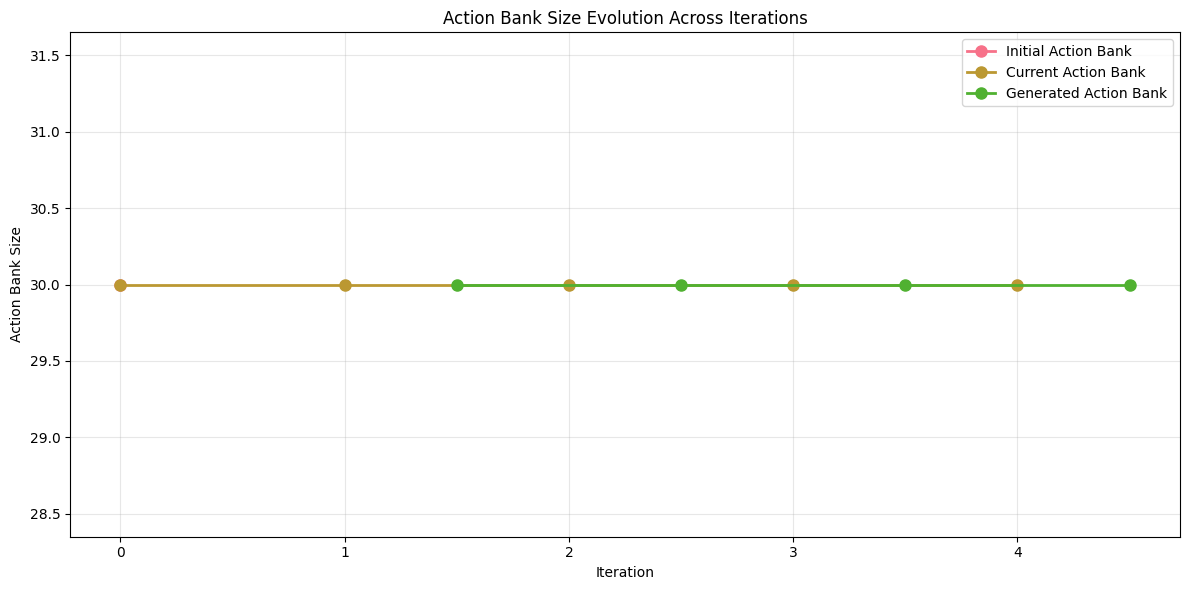

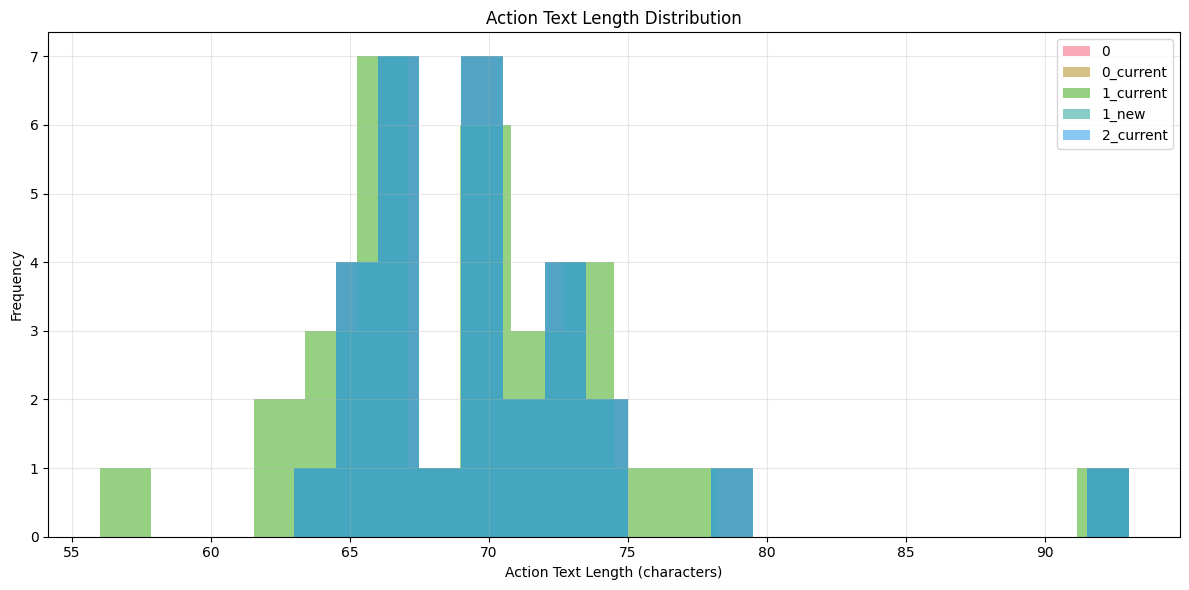

In [6]:
# Visualize action bank evolution
if experiment_path.exists() and action_banks:
    # Track action bank sizes across iterations
    iterations = []
    bank_sizes = []
    bank_types = []
    
    for bank_key, bank_data in action_banks.items():
        if isinstance(bank_key, int):  # Initial bank
            iterations.append(bank_key)
            bank_sizes.append(len(bank_data.get('actions', [])))
            bank_types.append('Initial')
        elif '_current' in str(bank_key):
            iter_num = int(str(bank_key).split('_')[0])
            iterations.append(iter_num)
            bank_sizes.append(len(bank_data.get('actions', [])))
            bank_types.append('Current')
        elif '_new' in str(bank_key):
            iter_num = int(str(bank_key).split('_')[0])
            iterations.append(iter_num + 0.5)  # Offset for visualization
            bank_sizes.append(len(bank_data.get('actions', [])))
            bank_types.append('Generated')
    
    # Plot action bank size evolution
    plt.figure(figsize=(12, 6))
    
    # Group by type for plotting
    df_viz = pd.DataFrame({
        'iteration': iterations,
        'size': bank_sizes,
        'type': bank_types
    })
    
    for bank_type in df_viz['type'].unique():
        type_data = df_viz[df_viz['type'] == bank_type]
        plt.plot(type_data['iteration'], type_data['size'], 
                marker='o', label=f'{bank_type} Action Bank', linewidth=2, markersize=8)
    
    plt.xlabel('Iteration')
    plt.ylabel('Action Bank Size')
    plt.title('Action Bank Size Evolution Across Iterations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Action text length analysis
    if len(action_banks) > 1:
        plt.figure(figsize=(12, 6))
        
        for i, (bank_key, bank_data) in enumerate(list(action_banks.items())[:5]):  # Show first 5 banks
            actions = bank_data.get('actions', [])
            if actions:
                text_lengths = [len(action.get('text', '')) for action in actions]
                plt.hist(text_lengths, alpha=0.6, label=f'{bank_key}', bins=20)
        
        plt.xlabel('Action Text Length (characters)')
        plt.ylabel('Frequency')
        plt.title('Action Text Length Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## 4. Observation Data Analysis

In [7]:
# Load and analyze observation data
def load_observations(experiment_path):
    """Load observation data from all iterations."""
    all_observations = []
    iteration_stats = {}
    
    iteration_dirs = sorted([d for d in experiment_path.glob("iteration_*") if d.is_dir()])
    
    for iter_dir in iteration_dirs:
        iter_num = int(iter_dir.name.split("_")[1])
        obs_file = iter_dir / "observations" / "observations.csv"
        
        if obs_file.exists():
            df = pd.read_csv(obs_file)
            df['iteration'] = iter_num
            all_observations.append(df)
            
            iteration_stats[iter_num] = {
                'total_observations': len(df),
                'positive_rate': df['reward'].mean(),
                'unique_users': df['user_id'].nunique(),
                'unique_actions': df['action_id'].nunique()
            }
    
    if all_observations:
        combined_df = pd.concat(all_observations, ignore_index=True)
        return combined_df, iteration_stats
    else:
        return None, {}

if experiment_path.exists():
    observations_df, iteration_stats = load_observations(experiment_path)
    
    if observations_df is not None:
        print(f"📊 Observation Data Analysis:")
        print(f"  Total observations: {len(observations_df):,}")
        print(f"  Iterations with data: {len(iteration_stats)}")
        print(f"  Overall positive rate: {observations_df['reward'].mean():.3f}")
        print(f"  Unique users: {observations_df['user_id'].nunique()}")
        print(f"  Unique actions: {observations_df['action_id'].nunique()}")
        
        print(f"\n📈 Per-Iteration Statistics:")
        print(f"{'Iteration':<10} {'Observations':<12} {'Pos Rate':<10} {'Users':<8} {'Actions':<8}")
        print("-" * 60)
        
        for iter_num, stats in iteration_stats.items():
            print(f"{iter_num:<10} {stats['total_observations']:<12,} "
                  f"{stats['positive_rate']:<10.3f} {stats['unique_users']:<8} {stats['unique_actions']:<8}")
        
        # Action performance analysis
        print(f"\n🎯 Action Performance Analysis:")
        action_stats = observations_df.groupby('action_id').agg({
            'reward': ['count', 'mean', 'sum'],
            'user_id': 'nunique'
        }).round(3)
        
        action_stats.columns = ['observations', 'conversion_rate', 'total_conversions', 'unique_users']
        action_stats = action_stats.sort_values('conversion_rate', ascending=False)
        
        print(f"  Top 10 performing actions:")
        print(action_stats.head(10))
        
        print(f"\n  Bottom 5 performing actions:")
        print(action_stats.tail(5))
        
    else:
        print("❌ No observation data found")
else:
    print("❌ Experiment directory not found")

📊 Observation Data Analysis:
  Total observations: 40,000
  Iterations with data: 4
  Overall positive rate: 0.719
  Unique users: 10000
  Unique actions: 30

📈 Per-Iteration Statistics:
Iteration  Observations Pos Rate   Users    Actions 
------------------------------------------------------------
1          10,000       0.826      10000    30      
2          10,000       0.653      10000    30      
3          10,000       0.692      10000    30      
4          10,000       0.705      10000    29      

🎯 Action Performance Analysis:
  Top 10 performing actions:
             observations  conversion_rate  total_conversions  unique_users
action_id                                                                  
action_0023          1230            0.939               1155          1200
action_0029           459            0.861                395           419
action_0018          6082            0.803               4885          2547
action_0019          1139            0.803    

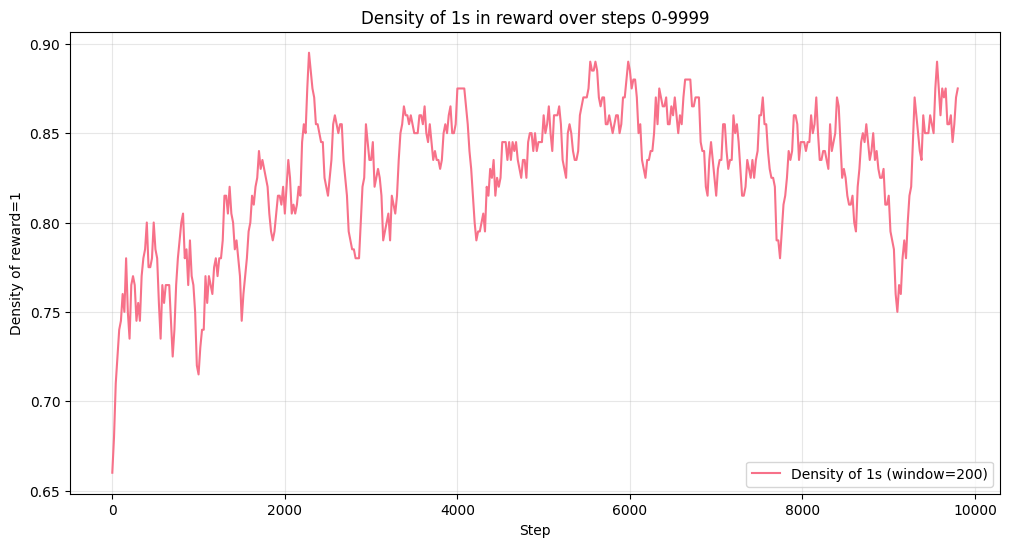

In [13]:
# Visualize the density of 1s (reward=1) in moving windows over steps 0-9999
import matplotlib.pyplot as plt
import numpy as np

rewards = observations_df[:10000]['reward'].values

window_size = 200  # You can adjust this for smoother or more granular density
step = 20          # Slide the window by this many steps

moving_density = [
    rewards[i:i+window_size].mean()
    for i in range(0, len(rewards) - window_size + 1, step)
]
steps = np.arange(0, len(moving_density)) * step

plt.figure(figsize=(12, 6))
plt.plot(steps, moving_density, label=f'Density of 1s (window={window_size})')
plt.xlabel('Step')
plt.ylabel('Density of reward=1')
plt.title('Density of 1s in reward over steps 0-9999')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

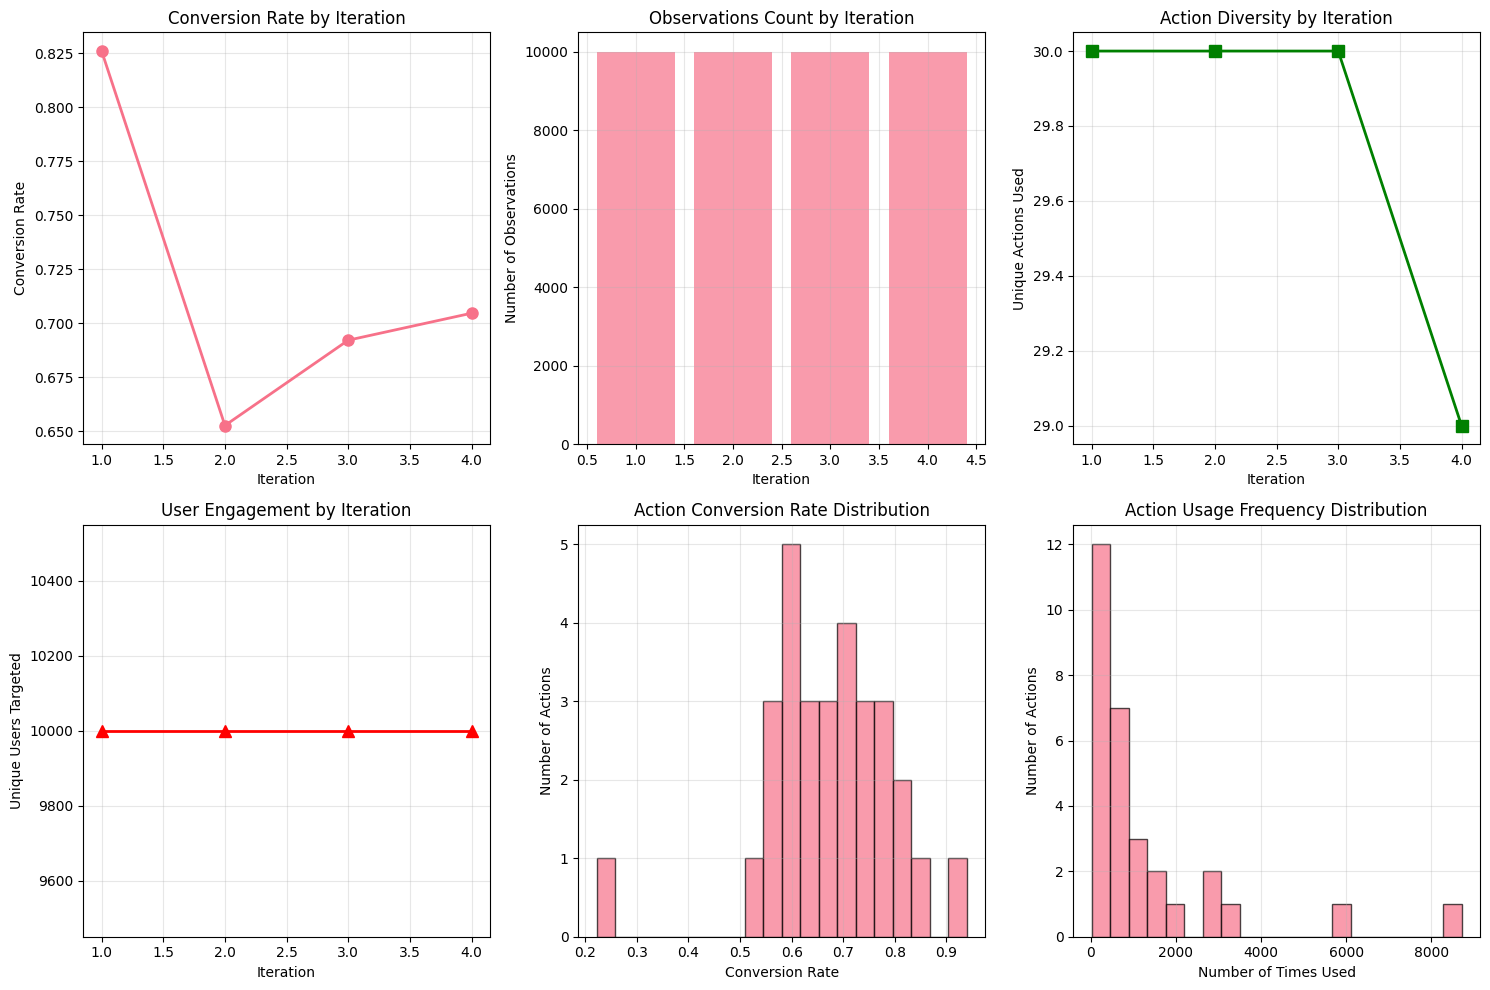


👥 Performance by User Segment:
                          observations  conversion_rate  total_conversions  \
user_segment                                                                 
budget_conscious_family           9920            0.742               7363   
middle_aged_professional         12108            0.684               8282   
premium_customer                  8124            0.634               5151   
young_tech_savvy                  9848            0.808               7957   

                          unique_actions  unique_users  
user_segment                                            
budget_conscious_family               30          2480  
middle_aged_professional              30          3027  
premium_customer                      30          2031  
young_tech_savvy                      29          2462  


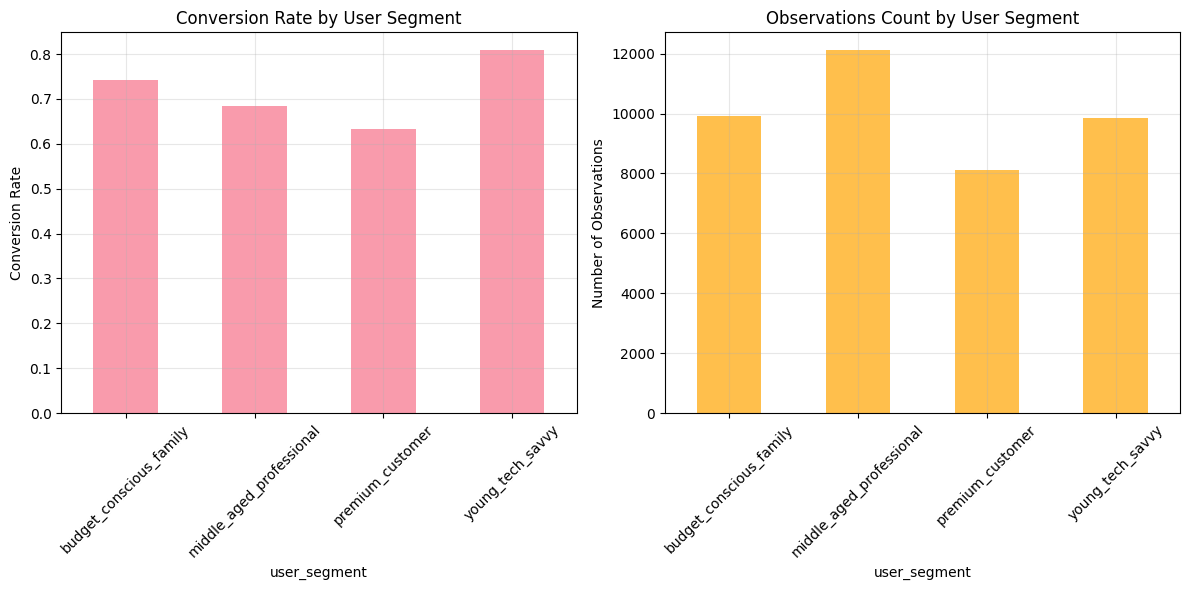

In [8]:
# Visualize observation patterns
if experiment_path.exists() and observations_df is not None:
    
    # 1. Conversion rate by iteration
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Conversion rate trends
    plt.subplot(2, 3, 1)
    iteration_conversion = observations_df.groupby('iteration')['reward'].mean()
    plt.plot(iteration_conversion.index, iteration_conversion.values, marker='o', linewidth=2, markersize=8)
    plt.title('Conversion Rate by Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Conversion Rate')
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Observations count by iteration
    plt.subplot(2, 3, 2)
    iteration_counts = observations_df.groupby('iteration').size()
    plt.bar(iteration_counts.index, iteration_counts.values, alpha=0.7)
    plt.title('Observations Count by Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Number of Observations')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Action diversity by iteration
    plt.subplot(2, 3, 3)
    action_diversity = observations_df.groupby('iteration')['action_id'].nunique()
    plt.plot(action_diversity.index, action_diversity.values, marker='s', linewidth=2, markersize=8, color='green')
    plt.title('Action Diversity by Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Unique Actions Used')
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: User engagement by iteration
    plt.subplot(2, 3, 4)
    user_engagement = observations_df.groupby('iteration')['user_id'].nunique()
    plt.plot(user_engagement.index, user_engagement.values, marker='^', linewidth=2, markersize=8, color='red')
    plt.title('User Engagement by Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Unique Users Targeted')
    plt.grid(True, alpha=0.3)
    
    # Subplot 5: Conversion rate distribution
    plt.subplot(2, 3, 5)
    plt.hist(action_stats['conversion_rate'], bins=20, alpha=0.7, edgecolor='black')
    plt.title('Action Conversion Rate Distribution')
    plt.xlabel('Conversion Rate')
    plt.ylabel('Number of Actions')
    plt.grid(True, alpha=0.3)
    
    # Subplot 6: Action usage frequency
    plt.subplot(2, 3, 6)
    action_usage = observations_df['action_id'].value_counts()
    plt.hist(action_usage.values, bins=20, alpha=0.7, edgecolor='black')
    plt.title('Action Usage Frequency Distribution')
    plt.xlabel('Number of Times Used')
    plt.ylabel('Number of Actions')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # User segment performance analysis
    if 'users_data' in locals() and users_data:
        # Create user segment mapping
        user_segment_map = {user['user_id']: user.get('segment', 'unknown') 
                           for user in users_data['users']}
        
        # Add segment info to observations
        observations_df['user_segment'] = observations_df['user_id'].map(user_segment_map)
        
        # Analyze performance by segment
        segment_performance = observations_df.groupby('user_segment').agg({
            'reward': ['count', 'mean', 'sum'],
            'action_id': 'nunique',
            'user_id': 'nunique'
        }).round(3)
        
        segment_performance.columns = ['observations', 'conversion_rate', 'total_conversions', 
                                     'unique_actions', 'unique_users']
        
        print(f"\n👥 Performance by User Segment:")
        print(segment_performance)
        
        # Visualize segment performance
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        segment_performance['conversion_rate'].plot(kind='bar', alpha=0.7)
        plt.title('Conversion Rate by User Segment')
        plt.ylabel('Conversion Rate')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        segment_performance['observations'].plot(kind='bar', alpha=0.7, color='orange')
        plt.title('Observations Count by User Segment')
        plt.ylabel('Number of Observations')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 5. Algorithm Performance Analysis

In [ ]:
# Load algorithm results and ground truth evaluations
def load_algorithm_results(experiment_path):
    """Load algorithm results from all iterations."""
    algorithm_results = {}
    ground_truth_results = {}
    
    iteration_dirs = sorted([d for d in experiment_path.glob("iteration_*") if d.is_dir()])
    
    for iter_dir in iteration_dirs:
        iter_num = int(iter_dir.name.split("_")[1])
        
        # Algorithm results
        algo_file = iter_dir / "algorithm_results.json"
        if algo_file.exists():
            with open(algo_file, 'r') as f:
                algorithm_results[iter_num] = json.load(f)
        
        # Ground truth evaluation
        gt_file = iter_dir / "ground_truth_evaluation.json"
        if gt_file.exists():
            with open(gt_file, 'r') as f:
                ground_truth_results[iter_num] = json.load(f)
    
    return algorithm_results, ground_truth_results

if experiment_path.exists():
    algorithm_results, ground_truth_results = load_algorithm_results(experiment_path)
    
    if algorithm_results:
        print(f"🔬 Algorithm Performance Analysis:")
        print(f"  Iterations with algorithm results: {len(algorithm_results)}")
        print(f"  Iterations with ground truth evaluation: {len(ground_truth_results)}")
        
        # Extract performance metrics
        iterations = []
        expected_values = []
        ground_truth_rewards = []
        correlations = []
        training_aucs = []
        
        print(f"\n📊 Per-Iteration Performance:")
        print(f"{'Iter':<5} {'Expected Value':<15} {'GT Reward':<12} {'GT Corr':<10} {'Train AUC':<10}")
        print("-" * 70)
        
        for iter_num in sorted(algorithm_results.keys()):
            algo_data = algorithm_results[iter_num]
            iterations.append(iter_num)
            
            # Expected value from algorithm
            expected_val = algo_data.get('evaluation_results', {}).get('total_value', 0)
            expected_values.append(expected_val)
            
            # Ground truth reward
            gt_reward = 0
            if iter_num in ground_truth_results:
                gt_reward = ground_truth_results[iter_num].get('average_expected_reward', 0)
            ground_truth_rewards.append(gt_reward)
            
            # Model evaluation metrics
            model_eval = algo_data.get('model_evaluation_results', {}).get('reward_model_evaluation', {})
            correlation = model_eval.get('correlation', 0)
            correlations.append(correlation)
            
            # Training metrics
            train_results = algo_data.get('training_results', {}).get('reward_model', {})
            train_auc = train_results.get('val_auc', 0)
            training_aucs.append(train_auc)
            
            print(f"{iter_num:<5} {expected_val:<15.4f} {gt_reward:<12.4f} {correlation:<10.3f} {train_auc:<10.3f}")
        
        # Summary statistics
        if len(expected_values) > 1:
            print(f"\n📈 Performance Summary:")
            print(f"  Expected Value - Mean: {np.mean(expected_values):.4f}, Final: {expected_values[-1]:.4f}")
            print(f"  GT Reward - Mean: {np.mean(ground_truth_rewards):.4f}, Final: {ground_truth_rewards[-1]:.4f}")
            print(f"  GT Correlation - Mean: {np.mean([c for c in correlations if c != 0]):.3f}")
            print(f"  Training AUC - Mean: {np.mean([a for a in training_aucs if a != 0]):.3f}")
    
    else:
        print("❌ No algorithm results found")
else:
    print("❌ Experiment directory not found")

In [ ]:
# Visualize algorithm performance trends
if experiment_path.exists() and algorithm_results and len(iterations) > 1:
    
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Expected value vs Ground truth reward
    plt.subplot(2, 3, 1)
    plt.plot(iterations, expected_values, marker='o', label='Expected Value', linewidth=2, markersize=8)
    plt.plot(iterations, ground_truth_rewards, marker='s', label='Ground Truth Reward', linewidth=2, markersize=8)
    plt.title('Algorithm Performance vs Ground Truth')
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Model correlation with ground truth
    plt.subplot(2, 3, 2)
    valid_correlations = [(i, c) for i, c in zip(iterations, correlations) if c != 0]
    if valid_correlations:
        iter_vals, corr_vals = zip(*valid_correlations)
        plt.plot(iter_vals, corr_vals, marker='^', linewidth=2, markersize=8, color='green')
    plt.title('Model Correlation with Ground Truth')
    plt.xlabel('Iteration')
    plt.ylabel('Correlation')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Training AUC progression
    plt.subplot(2, 3, 3)
    valid_aucs = [(i, a) for i, a in zip(iterations, training_aucs) if a != 0]
    if valid_aucs:
        iter_vals, auc_vals = zip(*valid_aucs)
        plt.plot(iter_vals, auc_vals, marker='d', linewidth=2, markersize=8, color='red')
    plt.title('Training AUC Progression')
    plt.xlabel('Iteration')
    plt.ylabel('AUC')
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Performance improvement
    plt.subplot(2, 3, 4)
    if len(expected_values) > 1:
        improvements = [expected_values[i] - expected_values[i-1] for i in range(1, len(expected_values))]
        plt.bar(iterations[1:], improvements, alpha=0.7)
    plt.title('Performance Improvement per Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Expected Value Change')
    plt.grid(True, alpha=0.3)
    
    # Subplot 5: Cumulative observations vs performance
    if 'observations_df' in locals() and observations_df is not None:
        plt.subplot(2, 3, 5)
        cumulative_obs = []
        cumulative_count = 0
        for iter_num in iterations:
            if iter_num in iteration_stats:
                cumulative_count += iteration_stats[iter_num]['total_observations']
            cumulative_obs.append(cumulative_count)
        
        plt.scatter(cumulative_obs, expected_values, s=100, alpha=0.7)
        plt.title('Performance vs Cumulative Observations')
        plt.xlabel('Cumulative Observations')
        plt.ylabel('Expected Value')
        plt.grid(True, alpha=0.3)
    
    # Subplot 6: Algorithm efficiency (performance per observation)
    plt.subplot(2, 3, 6)
    if 'observations_df' in locals() and observations_df is not None:
        efficiency = []
        for i, iter_num in enumerate(iterations):
            if iter_num in iteration_stats and iteration_stats[iter_num]['total_observations'] > 0:
                eff = expected_values[i] / iteration_stats[iter_num]['total_observations']
                efficiency.append(eff)
            else:
                efficiency.append(0)
        
        plt.plot(iterations, efficiency, marker='o', linewidth=2, markersize=8, color='purple')
        plt.title('Algorithm Efficiency (Value/Observation)')
        plt.xlabel('Iteration')
        plt.ylabel('Efficiency')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. Summary and Next Steps

This notebook provides a comprehensive analysis of the experiment data structure and key statistics:

### Key Insights:
1. **User Analysis**: 8-dimensional feature space with 4 distinct user segments
2. **Action Banks**: Evolution of marketing content across iterations with category diversity
3. **Observations**: User-action interaction data with conversion tracking
4. **Algorithm Performance**: Expected value improvements and ground truth correlations

### To Use This Notebook:
1. Change `EXPERIMENT_DIR` to your specific experiment directory
2. Run all cells to get complete analysis
3. Examine plots and statistics for insights into your experiment

### Experiment Directory Structure:
```
results/simulation_YYYYMMDD_HHMMSS/
├── simulation_config.json          # Experiment configuration
├── iteration_0/
│   ├── users/ (users.json, user_segments.json)
│   └── action_bank/ (action_bank.json)
├── iteration_N/
│   ├── observations/ (observations.csv)
│   ├── action_bank/ (action_bank.json)
│   ├── new_action_bank/ (new_action_bank.json)
│   ├── algorithm_results.json
│   └── ground_truth_evaluation.json
└── final_simulation_results.json
```